In [ ]:
# Adaptado de:
# https://github.com/naokishibuya/deep-learning/blob/master/python/dcgan_celeba.ipynb

# Generación de caras con GANs

In [ ]:
TRAIN    = True

COLAB    = True
GRAPHVIZ = True

In [ ]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 7.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import keras.backend as K
from keras.initializers import RandomNormal
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Leer base de datos

In [ ]:
if COLAB:
    try:
        from google_drive_downloader import GoogleDriveDownloader as gdd
    except:
        !pip install googledrivedownloader
        from google_drive_downloader import GoogleDriveDownloader as gdd
    
    gdd.download_file_from_google_drive(file_id='1JLrGRDrbk1EHh8bMKWP7A-6Cu_RGIJxC',
                                        dest_path='./caras.zip', unzip=True)

Unzipping...Done.


In [ ]:
!pwd

/content


In [ ]:
filenames = np.array(glob('./caras/famosos/*.jpg'))
filenames

array(['./caras/famosos/Alvaro_Uribe_0017.jpg',
       './caras/famosos/Arnold_Palmer_0002.jpg',
       './caras/famosos/Jackie_Chan_0006.jpg', ...,
       './caras/famosos/Carlos_Alberto_0001.jpg',
       './caras/famosos/Adam_Scott_0001.jpg',
       './caras/famosos/Carlos_Alberto_Parreira_0001.jpg'], dtype='<U53')

Let's examine some sample images.

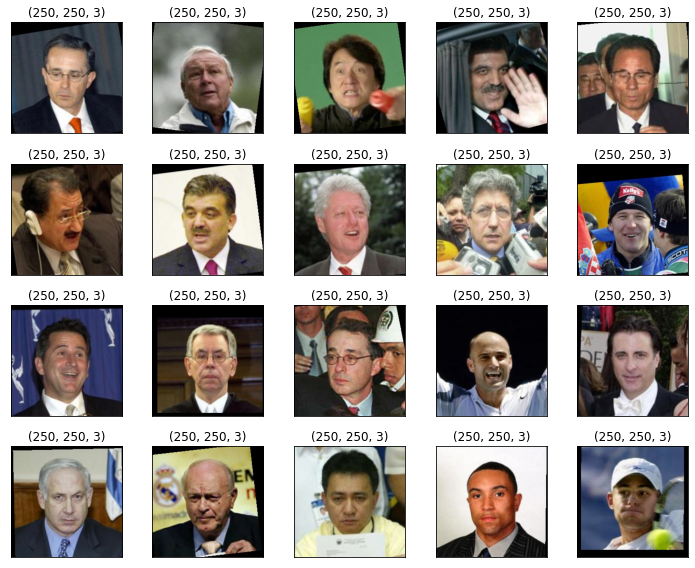

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(20):
    img = plt.imread(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [ ]:
X_train, X_test = train_test_split(filenames, test_size=200)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(883,)
(200,)


## Preprocessing and Deprocessing

Those images are pretty big.  I'll crop and resize.

In [ ]:
from PIL import Image

def load_image(filename, size=(32, 32)):
    img = np.array(Image.open(filename))
    # crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    # resize
    img = np.array(Image.fromarray(img).resize(size))
    return img

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


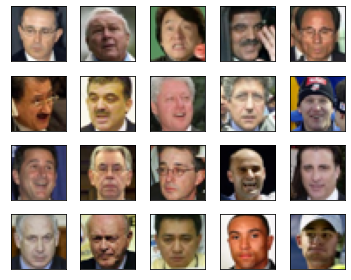

In [ ]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = load_image(filenames[i])
    print(np.array(img).shape)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [ ]:
def preprocess(x):
    return 2*(x/255)-1

def deprocess(x):
    return np.uint8((x+1)/2*255) # make sure to use uint8 type otherwise the image won't display properly

## Generator

The generator takes a latent sample (100 randomly generated numbers) and produces a color face image that should look like one from the CelebA dataset.

In [ ]:
def make_generator(input_size, leaky_alpha, init_stddev):
    model = Sequential()
    model.add(Dense(512*4*4, input_shape=(input_size,)))
    model.add(Reshape(target_shape=(4,4,512))) # 512 imgs de 4x4
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2DTranspose(256, kernel_size=5, strides=2, # upsampling + convolución
                              padding='same',
                              kernel_initializer=RandomNormal(stddev=init_stddev)
                             )) #  256 imgs de 8x8
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2,
                              padding='same',
                              kernel_initializer=RandomNormal(stddev=init_stddev)
                             )) #  128 imgs de 16x16
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2,
                              padding='same',
                              kernel_initializer=RandomNormal(stddev=init_stddev)
                             )) #  3 imgs de 32x32
    model.add(Activation('tanh'))
    
    return model


## Discriminator

The discriminator is a classifier to tell if the input image is real or fake.  

In [ ]:
def make_discriminator(leaky_alpha, init_stddev):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=2,
                     padding='same', input_shape=(32,32,3),
                     kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2D(128, kernel_size=5, strides=2,
                     padding='same',
                     kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2D(256, kernel_size=5, strides=2,
                     padding='same',
                     kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Flatten())
    model.add(Dense(1,
                    kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(Activation('sigmoid'))
    
    return model


## DCGAN

We connect the generator and the discriminator to make a DCGAN.

In [ ]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate, 
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha,
               init_std):
    # generator
    generator = make_generator(sample_size, leaky_alpha, init_std)

    # discriminator
    discriminator = make_discriminator(leaky_alpha, init_std)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a list of utility functions.

In [ ]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable
        
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

def show_losses_and_errors(losses, errors):
    losses = np.array(losses)
    errors = np.array(errors)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(errors.T[0], label='Discriminator')
    plt.plot(errors.T[1], label='Generator')
    plt.title("Validation Errors")
    plt.legend()
    plt.show()

def show_images(generated_images, cols=10):
    n_images = len(generated_images)
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

### Training

Smaller learning rate for the generater and a bigger learning rate for the discriminator.

In [ ]:
g_learning_rate=0.0001
g_beta_1=0.5
d_learning_rate=0.001
d_beta_1=0.5
leaky_alpha=0.2
init_std=0.02


smooth=0.1
sample_size=100 # latent sample size (i.e. 100 random numbers)
epochs=100 # 3
batch_size=16 # 128  # train batch size
eval_size=16    # evaluate size

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_DCGAN(
    sample_size, 
    g_learning_rate, 
    g_beta_1,
    d_learning_rate,
    d_beta_1,
    leaky_alpha,
    init_std)

losses = []
errors = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)        

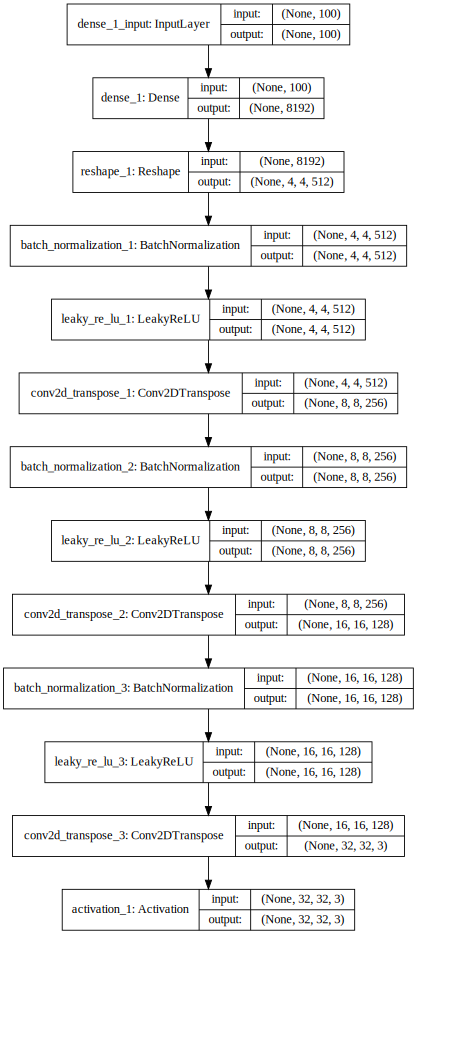

In [ ]:
print(generator.summary())
if GRAPHVIZ:
    from IPython.display import SVG,display
    from keras.utils.vis_utils import model_to_dot
    if COLAB:
        display(SVG(model_to_dot(generator,show_shapes=True,dpi=64).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(generator,show_shapes=True).create(prog='dot', format='svg')))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 256)        

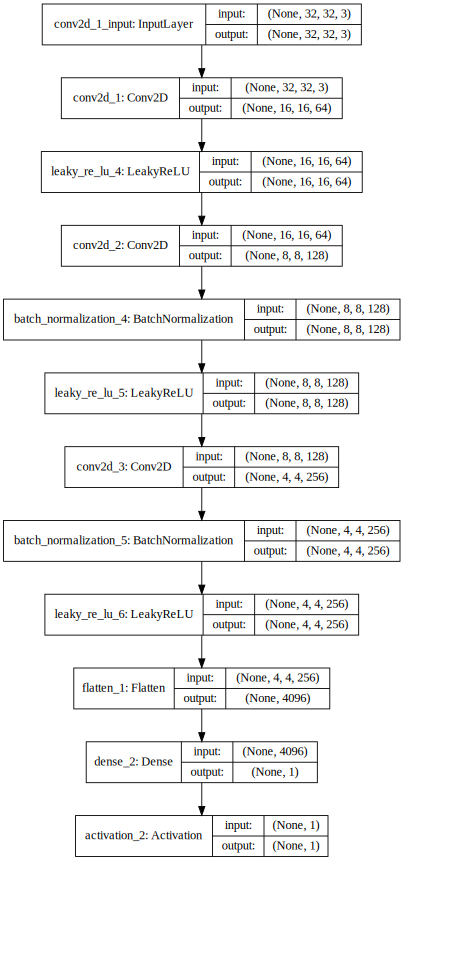

In [ ]:
print(discriminator.summary())
if GRAPHVIZ:
    if COLAB:
        display(SVG(model_to_dot(discriminator,show_shapes=True,dpi=64).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(discriminator,show_shapes=True).create(prog='dot', format='svg')))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         4936963   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1034881   
Total params: 5,971,844
Trainable params: 5,969,284
Non-trainable params: 2,560
_________________________________________________________________
None


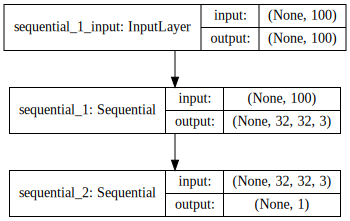

In [ ]:
print(gan.summary())
if GRAPHVIZ:
    if COLAB:
        display(SVG(model_to_dot(gan,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(gan,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
if TRAIN:
    for e in range(epochs):
        for i in tqdm(range(len(X_train)//batch_size)):
            # real CelebA images
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            X_batch_real = np.array([preprocess(load_image(filename)) for filename in X_batch])

             # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)        
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval = X_test[np.random.choice(len(X_test), eval_size, replace=False)]
        X_eval_real = np.array([preprocess(load_image(filename)) for filename in X_eval])

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        d_error = 0
        preds = discriminator.predict(X_eval_real).flatten().round()
        d_error += sum(preds!=y_eval_real[0][0])
        preds = discriminator.predict(X_eval_fake).flatten().round()
        d_error += sum(preds!=y_eval_fake[0][0])
        d_error /= (len(X_eval_real) + len(X_eval_fake))
        g_error = np.mean(gan.predict(latent_samples).flatten().round() != y_eval_real[0][0])

        errors.append((d_error, g_error))

        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))    
        show_images(X_eval_fake[:10])
        show_losses_and_errors(losses, errors)

    # show the result
    #show_losses(losses)
else:
    if COLAB:
        gdd.download_file_from_google_drive(file_id='1BbK3dG1O4LWPXN3ZniOPARJOoNClvTA9',
                                            dest_path='./discriminator_weights_1.h5', overwrite=True)
        gdd.download_file_from_google_drive(file_id='1rGu8vYbR4HoPoRZVstNtHjHRZuqjE4Qj',
                                            dest_path='./generator_weights_1.h5', overwrite=True)
    discriminator.load_weights("discriminator_weights_1.h5")
    generator.load_weights("generator_weights_1.h5")

show_images(generator.predict(make_latent_samples(80, sample_size)))

In [ ]:
#discriminator.save_weights("discriminator_weights_1.h5")
#generator.save_weights("generator_weights_1.h5")

In [ ]:
sample_size

100

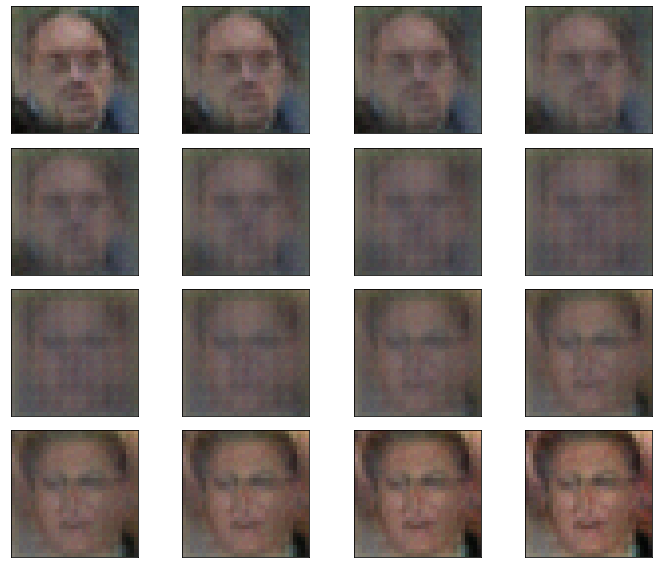

In [ ]:
N = 16
aux = np.zeros((N,100))
for i in range(4,5): # 10,11
    aux[:,i] = np.linspace(-5,5,N)
show_images(generator.predict(aux), cols=4)

In [ ]:
make_latent_samples(80, sample_size).shape

(80, 100)

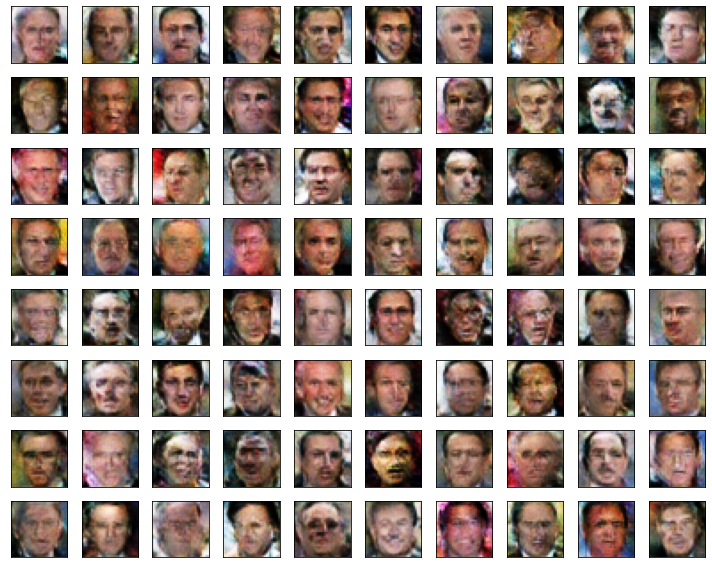

In [ ]:
show_images(generator.predict(make_latent_samples(80, sample_size)))

In [ ]:
generator.save("caras_famosos_generator.h5")
generator.save_weights("caras_famosos_generator_weights.h5")
discriminator.save("caras_famosos_discriminator.h5")
discriminator.save_weights("caras_famosos_discriminator_weights.h5")
gan.save("caras_famosos_gan.h5")
gan.save_weights("caras_famosos_gan_weights.h5")

In [ ]:
!ls -la

In [ ]:
if COLAB:
    from google.colab import files
    files.download('caras_famosos_generator.h5')
    files.download('caras_famosos_generator_weights.h5')
    files.download('caras_famosos_discriminator.h5')
    files.download('caras_famosos_discriminator_weights.h5')
    files.download('caras_famosos_gan.h5')
    files.download('caras_famosos_gan_weights.h5')